# T.U.I.A 2024 - Aprendizaje Automático II
## TP 2 - Redes Recurrentes
## Integrantes:
* Ponce, Daniel
* Yañez, Mirian

## Problema 2 - Shakespear

Descripción:

En el siguiente problema, se presenta un conjunto de datos correspondientes a escritos de Shakespear. El objetivo del problema es crear un modelo capaz de generar texto con dialecto de época y escritura en verso y prosa.

Dataset:
https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt


El dataset proporcionado incluye 40000 líneas de distintos escritos de Shakespear. Sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.

Objetivo:

Utilizando el dataset construido, el objetivo es construir modelos de generación de texto utilizando redes neuronales que puedan generar texto con dialecto de época y escritura en verso y prosa. Consultar el siguiente lab como referencia para la implementación:

https://colab.research.google.com/github/FCEIA-AAII/lab10/blob/master/lab10-a.ipynb

Se solicita experimentar con los siguientes tipos de modelos:

Caracter a caracter: entrenar un modelo de generación de texto a nivel de caracteres como el correspondiente al Lab10 mencionado anteriormente.

Palabra a palabra: entrenar un modelo de generación de texto a nivel de palabras, adecuando los procesos de entrenamiento e inferencia según sea necesario.

Generar fragmentos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.

Además se solicita evaluar el impacto de los siguiente factores sobre el texto generado:

Temperatura: Realizar ensayos con valores de temperatura =1, <1, >1.

Longitud de secuencia: Realizar ensayos con distintos valores de longitud de secuencia.

No se requiere un análisis de métricas para este problema, se espera un análisis cualitativo de los resultados obtenidos.

Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

Análisis previo y preprocesamiento del set de datos.

Definición y entrenamiento de los modelos.

Análisis y comparación de los resultados obtenidos para los diferentes modelos.

# Intalamos dependencias

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

# Librerias

In [2]:
import tensorflow as tf
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Definimos la clase 'BaseTextGenerator', que centraliza la lógica compartida para generadores de texto basados en RNN, incluyendo configuración, entrenamiento, y generación de texto.


In [4]:
class BaseTextGenerator(ABC):
    """
    Clase para la generación de texto, que proporciona lógica
    compartida para generadores a nivel de caracteres y a nivel de palabras.
    """

    def __init__(self, data_dir='.', embedding_dim=256, rnn_units=1024,
                 batch_size=64, seq_length=100):
        """
        Inicializa el generador de texto con parámetros compartidos.

        Argumentos:

        data_dir (str): Directorio para almacenar datos y puntos de control.
        embedding_dim (int): Dimensión de la capa de embeddings.
        rnn_units (int): Número de unidades en las capas RNN.
        batch_size (int): Tamaño del lote para el entrenamiento.
        seq_length (int): Longitud de las secuencias utilizadas para el entrenamiento.
        """
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(self.__class__.__name__)

        self.data_dir = data_dir
        self.embedding_dim = embedding_dim
        self.rnn_units = rnn_units
        self.batch_size = batch_size
        self.seq_length = seq_length

        self.vocabulary = None
        self.ids_from_tokens = None
        self.tokens_from_ids = None
        self.training_dataset = None
        self.validation_dataset = None
        self.model = None
        self.corpus = None
        self.token_type = None

        self.history = None

        self._configure_gpu()

    def _configure_gpu(self):
        """
        Configura TensorFlow para usar la GPU si está disponible.
        """
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                self.logger.info(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
            except RuntimeError as e:
                self.logger.error(f"Error al configurar la GPU: {e}")

    @abstractmethod
    def load_data(self):
        """
        Método para cargar y preprocesar datos.
        """
        pass

    @abstractmethod
    def prepare_dataset(self):
        """
        Método abstracto para preparar el conjunto de datos para el entrenamiento.
        """
        pass

    def build_model(self):
        """
        Construye el modelo de generación de texto basado en RNN.
        """
        try:
            vocab_size = len(self.ids_from_tokens.get_vocabulary())
            self.model = self.create_model(vocab_size)
            sample_input = tf.zeros([self.batch_size, self.seq_length], dtype=tf.int32)
            self.model(sample_input)
            self.model.summary(print_fn=self.logger.info)
            self.logger.info("Modelo construido con éxito.")
        except Exception as e:
            self.logger.error(f"Error al construir el modelo: {e}")

    @abstractmethod
    def create_model(self, vocab_size):
        """
        Método para crear el modelo. Esto permite que las subclases definan diferentes arquitecturas.
        """
        pass

    def compile_model(self):
        """
        Compila el modelo con un optimizador y una función de pérdida adecuados.
        """
        try:
            loss_function = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
            self.model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
            self.logger.info("Modelo compilado con éxito..")
        except Exception as e:
            self.logger.error(f"Error al compilar el modelo: {e}")

    def train_model(self, epochs=40):
        """
        Entrena el modelo utilizando el conjunto de datos preparado.

        Argumentos:

        epochs (int): Número de épocas para el entrenamiento.
        """
        try:
            checkpoint_dir = os.path.join(self.data_dir, 'training_checkpoints')
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
            checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_prefix,
                save_weights_only=True
            )

            # Callback personalizado para registrar la pérdida y la perplejidad.
            class PerplexityCallback(tf.keras.callbacks.Callback):
                def __init__(self):
                    super().__init__()
                    self.train_perplexity = []
                    self.val_perplexity = []

                def on_epoch_end(self, epoch, logs=None):
                    train_loss = logs.get('loss')
                    val_loss = logs.get('val_loss')
                    if train_loss is not None:
                        self.train_perplexity.append(np.exp(train_loss))
                    if val_loss is not None:
                        self.val_perplexity.append(np.exp(val_loss))

            self.perplexity_callback = PerplexityCallback()

            self.history = self.model.fit(
                self.training_dataset,
                validation_data=self.validation_dataset,
                epochs=epochs,
                callbacks=[checkpoint_callback, self.perplexity_callback]
            )
            self.logger.info("Modelo entrenado con éxito.")
        except Exception as e:
            self.logger.error(f"Error al entrenar el modelo: {e}")

    def plot_loss_and_perplexity(self):
        """
        Grafica la pérdida y la perplejidad a lo largo de las épocas.
        """
        if self.history is None:
            self.logger.error("No se encontró un historial de entrenamiento. Entrena el modelo primero..")
            return

        epochs = range(1, len(self.history.history['loss']) + 1)

        # Gráfico de pérdida
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history.history['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.history.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Gráfico de perplejidad.
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.perplexity_callback.train_perplexity, 'b-', label='Training Perplexity')
        plt.plot(epochs, self.perplexity_callback.val_perplexity, 'r-', label='Validation Perplexity')
        plt.title('Perplexity over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Perplexity')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def generate_text(self, start_string, num_generate=1000, temperature=1.0):
        """
        Genera texto utilizando el modelo entrenado.

        Argumentos:

        start_string (str): La cadena inicial para comenzar la generación de texto.
        num_generate (int): Número de tokens a generar.
        temperature (float): Parámetro de temperatura para la generación de texto.
        Devuelve:

        str: El texto generado.
        """
        try:
            input_tokens = self.preprocess_start_string(start_string)
            text_generated = []

            # Asegúrate de que la temperatura sea positiva.
            temperature = max(temperature, 1e-5)

            states = None
            for _ in range(num_generate):
                input_ids = self.ids_from_tokens(input_tokens)

                predictions, states = self.model(inputs=input_ids, states=states,
                                                 return_state=True)
                # Obtener la última predicción.
                predictions = predictions[:, -1, :]
                # Ajustar según la temperatura.
                predictions /= temperature
                # Muestrear el siguiente token.
                predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()
                # Decodificar a token.
                next_token = self.tokens_from_ids(predicted_id).numpy().decode('utf-8')
                # Preparar la siguiente entrada.
                if self.token_type == 'word':
                    input_tokens = tf.expand_dims([next_token], 0)
                else:
                    input_tokens = tf.expand_dims(list(next_token), 0)
                text_generated.append(next_token)

            if self.token_type == 'word':
                return start_string + ' ' + ' '.join(text_generated)
            else:
                return start_string + ''.join(text_generated)
        except Exception as e:
            self.logger.error(f"Error al generar texto: {e}")
            return ""

    @abstractmethod
    def preprocess_start_string(self, start_string):
        """
        Preprocesa la cadena inicial para la generación de texto.

        Argumentos:
          start_string (str): La cadena inicial.

        Devuelve:
          tf.Tensor: Los tokens de entrada procesados.
        """
        pass

## Implementamos la clase 'CharacterLevelTextGenerator', que extiende 'BaseTextGenerator' para generar texto a nivel de caracteres, incluyendo carga de datos, preparación de datasets y creación de modelos optimizados.


In [6]:
class CharacterLevelTextGenerator(BaseTextGenerator):
    """
    Generador de texto a nivel de caracteres que extiende la clase BaseTextGenerator..
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.token_type = 'char'

    def load_data(self):
        """
        Carga y preprocesa los datos para el entrenamiento a nivel de caracteres.
        """
        try:
            file_path = tf.keras.utils.get_file(
                fname='shakespeare.txt',
                origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
                cache_dir=self.data_dir
            )
            with open(file_path, 'rb') as f:
                self.corpus = f.read().decode(encoding='utf-8')
            self.vocabulary = sorted(set(self.corpus))
            self.ids_from_tokens = tf.keras.layers.StringLookup(
                vocabulary=list(self.vocabulary), mask_token=None
            )
            self.tokens_from_ids = tf.keras.layers.StringLookup(
                vocabulary=self.ids_from_tokens.get_vocabulary(),
                invert=True, mask_token=None
            )
            self.logger.info("Character-level cargado con éxito.")
        except Exception as e:
            self.logger.error(f"Error al cargar los datos: {e}")

    def prepare_dataset(self):
        """
        Prepara el conjunto de datos para el entrenamiento a nivel de caracteres creando secuencias de caracteres.
        """
        try:
            all_ids = self.ids_from_tokens(tf.strings.unicode_split(self.corpus, 'UTF-8'))
            ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
            sequences = ids_dataset.batch(self.seq_length + 1, drop_remainder=True)

            def split_input_target(sequence):
                input_text = sequence[:-1]
                target_text = sequence[1:]
                return input_text, target_text

            dataset = sequences.map(split_input_target)
            dataset = dataset.shuffle(buffer_size=10000)
            dataset_size = sum(1 for _ in dataset)
            train_size = int(dataset_size * 0.8)
            train_dataset = dataset.take(train_size)
            val_dataset = dataset.skip(train_size)

            self.training_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
            self.validation_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)
            self.logger.info("Character-level dataset preparado con éxito.")
        except Exception as e:
            self.logger.error(f"Error al preparar el conjunto de datos.: {e}")

    def preprocess_start_string(self, start_string):
        """

        Preprocesa la cadena inicial para la generación de texto a nivel de caracteres.

        Argumentos:
        start_string (str): La cadena inicial.

        Devuelve:
        tf.Tensor: Los tokens de entrada procesados.
        """
        input_tokens = tf.strings.unicode_split(start_string, 'UTF-8')
        input_tokens = tf.expand_dims(input_tokens, 0)
        return input_tokens

    def create_model(self, vocab_size):
        """
        Crea el modelo de generación de texto a nivel de caracteres con una arquitectura mejorada.
        """
        return TextGenerationModel(
            vocab_size=vocab_size,
            embedding_dim=self.embedding_dim,
            rnn_units=self.rnn_units,
            num_rnn_layers=2,
            use_lstm=True,
            dropout_rate=0.2
        )

## Implementamos la clase 'WordLevelTextGenerator', que extiende 'BaseTextGenerator' para generar texto a nivel de palabras, manejando la carga de datos, preparación de datasets y creación de modelos ajustados para dependencias a largo plazo.


In [7]:
class WordLevelTextGenerator(BaseTextGenerator):
    """
    Un generador de texto a nivel de palabras que extiende la clase `BaseTextGenerator`.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.token_type = 'word'

    def load_data(self):
        """
        Carga y preprocesa los datos para el entrenamiento a nivel de palabras..
        """
        try:
            file_path = tf.keras.utils.get_file(
                fname='shakespeare.txt',
                origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt',
                cache_dir=self.data_dir
            )
            with open(file_path, 'rb') as f:
                self.corpus = f.read().decode(encoding='utf-8')
            tokens = self.corpus.split()
            self.vocabulary = sorted(set(tokens))
            self.ids_from_tokens = tf.keras.layers.StringLookup(
                vocabulary=self.vocabulary, mask_token=None
            )
            self.tokens_from_ids = tf.keras.layers.StringLookup(
                vocabulary=self.ids_from_tokens.get_vocabulary(),
                invert=True, mask_token=None
            )
            self.logger.info("Word-level data cargado con éxito.")
        except Exception as e:
            self.logger.error(f"Error al cargar los datos: {e}")

    def prepare_dataset(self):
        """
        Prepara el conjunto de datos para el entrenamiento a nivel de palabras creando secuencias de palabras.
        """
        try:
            tokens = tf.strings.split(self.corpus)
            all_ids = self.ids_from_tokens(tokens)
            ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
            sequences = ids_dataset.batch(self.seq_length + 1, drop_remainder=True)

            def split_input_target(sequence):
                input_text = sequence[:-1]
                target_text = sequence[1:]
                return input_text, target_text

            dataset = sequences.map(split_input_target)
            dataset = dataset.shuffle(buffer_size=10000)
            dataset_size = sum(1 for _ in dataset)
            train_size = int(dataset_size * 0.8)
            train_dataset = dataset.take(train_size)
            val_dataset = dataset.skip(train_size)

            self.training_dataset = train_dataset.batch(self.batch_size, drop_remainder=True)
            self.validation_dataset = val_dataset.batch(self.batch_size, drop_remainder=True)
            self.logger.info("Word-level dataset preparado con éxito.")
        except Exception as e:
            self.logger.error(f"Error preparing dataset: {e}")

    def preprocess_start_string(self, start_string):
        """
        Preprocesa la cadena inicial para la generación de texto a nivel de palabras.

        Argumentos:
        start_string (str): La cadena inicial.

        Devuelve:
        tf.Tensor: Los tokens de entrada procesados.
        """
        input_tokens = tf.strings.split(start_string)
        input_tokens = tf.expand_dims(input_tokens, 0)
        return input_tokens

    def create_model(self, vocab_size):
        """
        Crea el modelo de generación de texto a nivel de palabras con una arquitectura mejorada.
        """
        return TextGenerationModel(
            vocab_size=vocab_size,
            embedding_dim=256,
            rnn_units=512,
            num_rnn_layers=2,
            use_lstm=True,
            dropout_rate=0.2,
        )

## Definimos la clase 'TextGenerationModel', un modelo basado en RNN diseñado para generar texto, con soporte para múltiples capas RNN (LSTM o GRU), embeddings y regularización mediante dropout.


In [8]:
class TextGenerationModel(tf.keras.Model):
    """
    Clase para generación de texto basada en RNN.
    """

    def __init__(self, vocab_size, embedding_dim, rnn_units, num_rnn_layers=1, use_lstm=False, dropout_rate=0.0):
        super().__init__()
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_layers = []
        for _ in range(num_rnn_layers):
            if use_lstm:
                rnn_layer = tf.keras.layers.LSTM(rnn_units,
                                                 return_sequences=True,
                                                 return_state=True,
                                                 dropout=dropout_rate)
            else:
                rnn_layer = tf.keras.layers.GRU(rnn_units,
                                                return_sequences=True,
                                                return_state=True,
                                                dropout=dropout_rate)
            self.rnn_layers.append(rnn_layer)
        self.dense_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        """
        Define el forward pass del modelo.
        """
        x = self.embedding_layer(inputs, training=training)
        new_states = []
        for idx, rnn_layer in enumerate(self.rnn_layers):
            if states is None:
                rnn_output = rnn_layer(x, training=training)
            else:
                rnn_output = rnn_layer(x, initial_state=states[idx], training=training)

            # Detect RNN layer type and unpack accordingly
            if isinstance(rnn_layer, tf.keras.layers.LSTM):
                # LSTM returns (output, h_state, c_state)
                x, h, c = rnn_output
                state = (h, c)
            elif isinstance(rnn_layer, tf.keras.layers.GRU):
                # GRU returns (output, h_state)
                x, h = rnn_output
                state = h
            else:
                raise ValueError("Tipo de capa RNN no compatible.")
            new_states.append(state)
        x = self.dense_layer(x, training=training)

        if return_state:
            return x, new_states
        else:
            return x

## Creamos una instancia de 'CharacterLevelTextGenerator', cargamos y preparamos los datos, construimos el modelo y lo compilamos para el entrenamiento.


In [9]:
char_generator = CharacterLevelTextGenerator()
char_generator.load_data()
char_generator.prepare_dataset()
char_generator.build_model()
char_generator.compile_model()

1115394/1115394 [==============================] - 1s 0us/step


## Entrenamos el modelo de 'CharacterLevelTextGenerator' durante 50 épocas utilizando los datos preparados.


In [10]:
char_generator.train_model(epochs=50)

Epoch 1/50
138/138 [==============================] - 35s 205ms/step - loss: 3.0546 - accuracy: 0.1989 - val_loss: 2.3825 - val_accuracy: 0.3200
Epoch 2/50
138/138 [==============================] - 32s 211ms/step - loss: 2.1459 - accuracy: 0.3786 - val_loss: 1.9194 - val_accuracy: 0.4371
Epoch 3/50
138/138 [==============================] - 32s 216ms/step - loss: 1.7996 - accuracy: 0.4688 - val_loss: 1.6378 - val_accuracy: 0.5126
Epoch 4/50
138/138 [==============================] - 34s 231ms/step - loss: 1.6046 - accuracy: 0.5205 - val_loss: 1.5026 - val_accuracy: 0.5477
Epoch 5/50
138/138 [==============================] - 32s 220ms/step - loss: 1.4847 - accuracy: 0.5509 - val_loss: 1.3956 - val_accuracy: 0.5734
Epoch 6/50
138/138 [==============================] - 34s 232ms/step - loss: 1.4082 - accuracy: 0.5698 - val_loss: 1.3265 - val_accuracy: 0.5908
Epoch 7/50
138/138 [==============================] - 33s 225ms/step - loss: 1.3483 - accuracy: 0.5848 - val_loss: 1.2806 - val_ac

## Visualizamos las curvas de pérdida y perplexidad del modelo durante el entrenamiento.


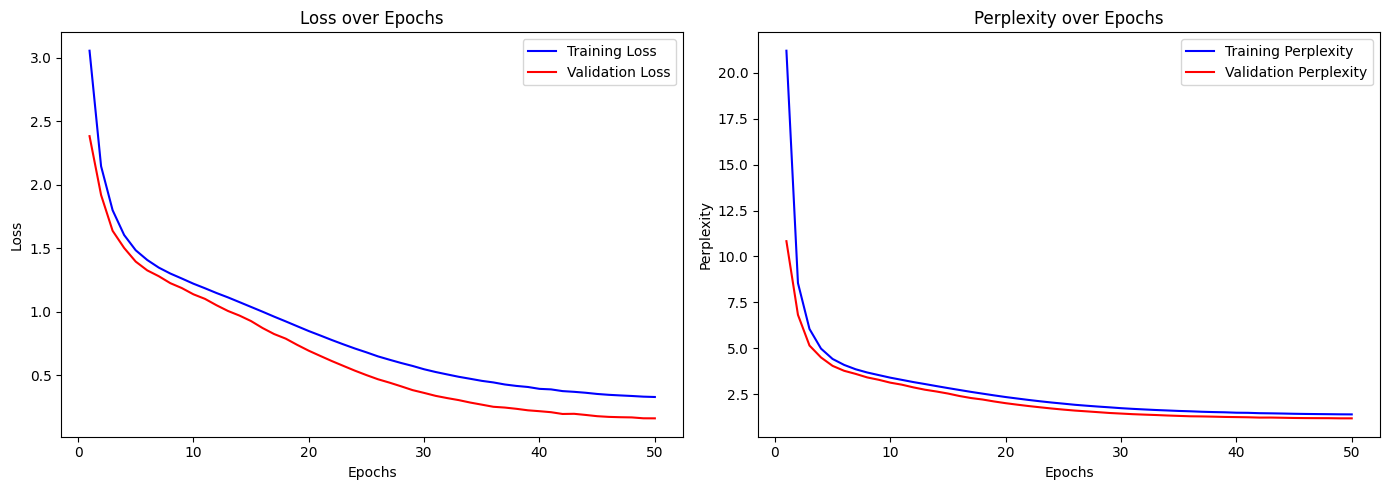

In [11]:
char_generator.plot_loss_and_perplexity()

# Ejemplo
## Generamos texto a nivel de caracteres utilizando diferentes valores de temperatura (0.2, 0.5, 1.0, 1.5) para explorar el impacto de la aleatoriedad en las predicciones del modelo.


In [12]:
temperatures = [0.2, 0.5, 1.0, 1.5]
for temp in temperatures:
    generated_text = char_generator.generate_text(
        start_string="To be, or not to be",
        num_generate=500,
        temperature=temp
    )
    print(f"\nGeneración a nivel de caracteres con temperatura={temp}:\n")
    print(generated_text)
    print("\n" + "="*80 + "\n")


Generación a nivel de caracteres con temperatura=0.2:

To be, or not to be revenged on him.

JULIET:
What stays had me of this swift banish'd drum,
That knows he is an hour as thou art now,
That, honourable state, which I do love to here,
Where thou shalt rest, that I may say, be gone.

RICHMOND:
God and your affairs is but a poison, where it
begin-cainst the state, whose bridegroom in the world
Where Clarence did show me once more a fortune's grave.
Where is the poor discorder of my lands
And hearten with the danger of his blood,
Her face be blood to be partly touch'



Generación a nivel de caracteres con temperatura=0.5:

To be, or not to be revenged on me!

CLIFFORD:
I would your highness would depart the field,
That will not be avoided but by this.
Therefore, good night; as sweet repose, with something
That now make clouds, whilst I have fought with thee
Stand for his majesty; being then with them!

BUCKINGHAM:
It is: and tell me who comes here?

NORTHUMBERLAND:
It shall be so, i

Podemos observar en los gráficos de pérdida y perplejidad una disminución consistente durante el entrenamiento, lo que indica que el modelo está aprendiendo y generalizando adecuadamente. También notamos que las métricas convergen hacia valores bajos tanto en los datos de entrenamiento como en los de validación, lo que sugiere que no hay un sobreajuste significativo y que el modelo mantiene un buen equilibrio entre ambos conjuntos.

En cuanto al texto generado, observamos que el modelo logra producir fragmentos con la estructura verso y prosa. Además, notamos que la variación en la temperatura afecta la creatividad del texto: con valores bajos, el texto tiende a ser más predecible y estructurado, mientras que con temperaturas más altas, se generan composiciones más diversas y creativas, aunque con cierta propensión a incoherencias menores.

## Creamos una instancia de 'WordLevelTextGenerator', cargamos y preparamos los datos a nivel de palabras, construimos el modelo y lo compilamos para su entrenamiento.


In [13]:
word_generator = WordLevelTextGenerator()
word_generator.load_data()
word_generator.prepare_dataset()
word_generator.build_model()
word_generator.compile_model()

## Entrenamos el modelo de 'WordLevelTextGenerator' durante 300 épocas utilizando los datos preparados.


In [14]:
word_generator.train_model(epochs=300)

Epoch 1/300
25/25 [==============================] - 15s 420ms/step - loss: 8.7052 - accuracy: 0.0252 - val_loss: 7.9062 - val_accuracy: 0.0264
Epoch 2/300
25/25 [==============================] - 9s 360ms/step - loss: 7.9140 - accuracy: 0.0268 - val_loss: 7.7642 - val_accuracy: 0.0271
Epoch 3/300
25/25 [==============================] - 10s 366ms/step - loss: 7.8001 - accuracy: 0.0268 - val_loss: 7.6739 - val_accuracy: 0.0264
Epoch 4/300
25/25 [==============================] - 9s 359ms/step - loss: 7.7905 - accuracy: 0.0267 - val_loss: 7.7112 - val_accuracy: 0.0264
Epoch 5/300
25/25 [==============================] - 10s 410ms/step - loss: 7.7816 - accuracy: 0.0254 - val_loss: 7.6731 - val_accuracy: 0.0276
Epoch 6/300
25/25 [==============================] - 9s 347ms/step - loss: 7.7701 - accuracy: 0.0265 - val_loss: 7.6566 - val_accuracy: 0.0272
Epoch 7/300
25/25 [==============================] - 9s 347ms/step - loss: 7.7740 - accuracy: 0.0264 - val_loss: 7.6657 - val_accuracy: 0.0

## Visualizamos las curvas de pérdida y perplexidad.


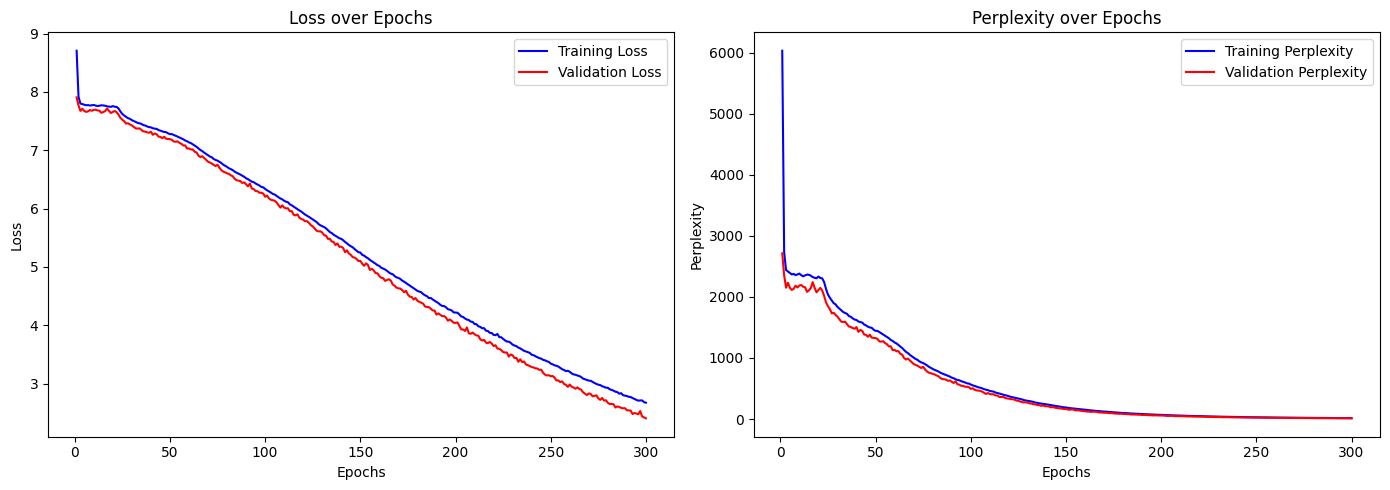

In [15]:
word_generator.plot_loss_and_perplexity()


## Generamos texto a nivel de palabras utilizando el modelo 'WordLevelTextGenerator' con diferentes valores de temperatura (0.2, 0.5, 1.0, 1.5) para observar cómo varía la coherencia y creatividad.


In [16]:
temperatures = [0.2, 0.5, 1.0, 1.5]
for temp in temperatures:
    generated_text = word_generator.generate_text(
        start_string="To be, or not to be",
        num_generate=50,
        temperature=temp
    )
    print(f"\nGeneración a nivel de palabras con temperatura={temp}:\n")
    print(generated_text)
    print("\n" + "="*80 + "\n")


Generación a nivel de palabras con temperatura=0.2:

To be, or not to be a rod, And fawn on fawn on his complices, in the rod, And fawn on vengeance and his knees to fawn upon the commonwealth, Which I have stay'd for London that he was so pace Than I have heard me then so long to be much As much and made.



Generación a nivel de palabras con temperatura=0.5:

To be, or not to be assured let them hear her. CAMILLO: I am a love of you; and now I To hear him yet he were in himself To see the wolf with breath? MONTAGUE: But that's a day of your grace, But in my king was a man To hear you: I'll be so



Generación a nivel de palabras con temperatura=1.0:

To be, or not to be a letters of mine complices, eyes with twenty than much In fit fair instruction, And with them oft doth show an deed I have know. WARWICK: Come hope to grace his majesty to know. DUKE OF YORK: whence thou wert so faintly and shall purpose be apt deep robes And



Generación a nivel de palabras con temperatura=1.5:

T

El modelo basado en la generación a nivel de palabras muestra un aprendizaje efectivo según los gráficos de pérdida y perplejidad, que disminuyen consistentemente durante el entrenamiento. Sin embargo, el texto generado carece de la estructura característica de verso y prosa. Esto se debe a que, al construir el diccionario de palabras, no se incluyeron los saltos de línea como elementos válidos, ya que no fueron considerados palabras. Esta omisión impide que el modelo capture y reproduzca la estructura literaria en líneas o versos, limitando su capacidad para imitar estilos clásicos.

A pesar de esta limitación, la variación en la temperatura demuestra el impacto esperado en la generación de texto: temperaturas más bajas producen frases más controladas y predecibles, mientras que temperaturas más altas generan resultados más variados y creativos, aunque con mayor riesgo de incoherencias. Para mejorar la capacidad del modelo de generar texto con una estructura literaria definida, tal como lo indica la consigna, sería necesario incluir los saltos de línea en el diccionario, permitiendo que estos formen parte del contexto utilizado durante la generación.

# Conclusión

En este ejercicio trabajamos con redes neuronales recurrentes (RNN), específicamente LSTM y GRU, para generar texto tanto a nivel de caracteres como de palabras, analizando cómo los parámetros del modelo, el entrenamiento y la temperatura influyen en el balance entre coherencia y creatividad del texto generado.

A nivel de caracteres, el modelo capturó patrones detallados del texto fuente, logrando generar secuencias que imitaban estilos literarios clásicos en verso y prosa. Temperaturas bajas resultaron en textos más coherentes pero repetitivos, mientras que temperaturas altas introdujeron mayor diversidad y creatividad, aunque con menor cohesión. Este enfoque permitió respetar elementos estructurales, como los saltos de línea, esenciales para imitar estilos clásicos.

En contraste, el modelo basado en palabras trabajó con unidades lingüísticas más complejas, mostrando capacidad para generar texto coherente a temperaturas bajas y más diverso a temperaturas altas, aunque con cierta desconexión en las frases. Sin embargo, al no incluir los saltos de línea en el diccionario, no logró replicar estructuras como versos y prosa, limitando su capacidad para imitar estilos literarios.

Las curvas de pérdida y perplejidad mostraron un entrenamiento estable y una adecuada generalización en ambos casos. Este análisis resaltó cómo la selección de parámetros, como la temperatura, la arquitectura del modelo y las unidades de entrada, influye directamente en el balance entre coherencia y creatividad. Además, permitió entender las fortalezas y limitaciones de cada enfoque, siendo clave ajustar estas variables según el contexto y las necesidades de la aplicación.